# TV Show Rating Decay Analysis: Do Shows Get Worse Over Time?
**Question:** 
Do long-running TV series suffer from “rating decay” — meaning, do their average episode ratings drop as seasons progress?

**Why this is important:**
- Do shows maintain quality over time?
- Should platforms expect later seasons to lose audience satisfaction?
- Which shows improve, which decline, and how common is decay overall?

In [10]:
import os
from pathlib import Path
import pandas as pd
import numpy as np
import kagglehub
import duckdb
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import linregress

sns.set(style='whitegrid')
plt.rcParams['figure.figsize'] = (11,6)
plt.rcParams['font.size'] = 12

MIN_VOTES = 20                # min numVotes to include an episode
MIN_SERIES_PER_SEASON = 10    # require this many series to include a season in global trend
MIN_SEASONS = 3               # min seasons to compute a per-series slope
MAX_SEASON_PLOT = 10
SHOWS_TO_ANALYZE = [
    "Game of Thrones",
    "Breaking Bad",
    "The Walking Dead",
    "Friends"
]
TOP_N_SHOWS = 20
MAX_SEASON_TOPN = 12


In [11]:
# Download dataset (Colab) and locate required files
path = kagglehub.dataset_download("vivekananda99/imdb-dataset")
print("Dataset downloaded to:", path)

# list files quickly
all_files = []
for root, _, fs in os.walk(path):
    for f in fs:
        all_files.append(os.path.join(root, f))

def find_file(prefix):
    for f in all_files:
        if os.path.basename(f).lower().startswith(prefix.lower()):
            return f
    return None

basics_fp = find_file('title.basics')
episodes_fp = find_file('title.episode')
ratings_fp = find_file('title.ratings')

if not (basics_fp and episodes_fp and ratings_fp):
    raise FileNotFoundError("Missing required IMDb files: title.basics*, title.episode*, title.ratings*")

print("Using files:")
print(" basics:", basics_fp)
print(" episodes:", episodes_fp)
print(" ratings:", ratings_fp)


Dataset downloaded to: /kaggle/input/imdb-dataset
Using files:
 basics: /kaggle/input/imdb-dataset/title.basics.tsv
 episodes: /kaggle/input/imdb-dataset/title.episode.tsv
 ratings: /kaggle/input/imdb-dataset/title.ratings.tsv


In [12]:
# Load raw tables into DuckDB (fast)
con = duckdb.connect(database=':memory:')

con.execute(f"""
CREATE TABLE title_basics AS
SELECT tconst, titleType, primaryTitle
FROM read_csv_auto('{basics_fp}', delim='\t', nullstr='\\N');
""")

con.execute(f"""
CREATE TABLE title_episodes_raw AS
SELECT tconst AS episode_tconst,
       parentTconst AS series_tconst,
       seasonNumber,
       episodeNumber
FROM read_csv_auto('{episodes_fp}', delim='\t', nullstr='\\N');
""")

con.execute(f"""
CREATE TABLE title_ratings AS
SELECT tconst AS episode_tconst,
       CAST(averageRating AS DOUBLE) AS averageRating,
       CAST(numVotes AS BIGINT) AS numVotes
FROM read_csv_auto('{ratings_fp}', delim='\t', nullstr='\\N');
""")

# Clean episodes: require numeric seasonNumber and non-null parent
con.execute("""
CREATE TABLE title_episodes AS
SELECT episode_tconst,
       series_tconst,
       TRY_CAST(seasonNumber AS INTEGER) AS seasonNumber,
       episodeNumber
FROM title_episodes_raw
WHERE series_tconst IS NOT NULL
  AND TRY_CAST(seasonNumber AS INTEGER) IS NOT NULL;
""")


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

In [13]:
# Join eps + ratings (filter low-vote noise)
con.execute(f"""
CREATE TABLE ep_with_ratings AS
SELECT e.episode_tconst, e.series_tconst, e.seasonNumber, r.averageRating, r.numVotes
FROM title_episodes e
LEFT JOIN title_ratings r ON e.episode_tconst = r.episode_tconst
WHERE r.averageRating IS NOT NULL
  AND r.numVotes >= {MIN_VOTES};
""")

# Aggregate to season-level (series,season)
con.execute("""
CREATE TABLE season_agg AS
SELECT series_tconst,
       seasonNumber,
       AVG(averageRating) AS season_mean_rating,
       STDDEV_SAMP(averageRating) AS season_std_rating,
       COUNT(*) AS season_count
FROM ep_with_ratings
GROUP BY series_tconst, seasonNumber;
""")

# Attach human-readable title
con.execute("""
CREATE TABLE season_agg_named AS
SELECT s.*,
       b.primaryTitle AS series_title
FROM season_agg s
LEFT JOIN title_basics b ON s.series_tconst = b.tconst;
""")

season_df = con.execute("SELECT * FROM season_agg_named").fetchdf()
season_df = season_df.dropna(subset=['seasonNumber']).copy()
season_df['seasonNumber'] = season_df['seasonNumber'].astype(int)
print("Season-level rows:", len(season_df))


Season-level rows: 42614


In [14]:
# Global: mean of season-means by seasonNumber
global_df = season_df.groupby('seasonNumber', as_index=False).agg(
    mean_of_season_means = ('season_mean_rating','mean'),
    std_of_season_means = ('season_mean_rating','std'),
    count_series = ('season_mean_rating','count')
).sort_values('seasonNumber')
global_df['sem'] = global_df['std_of_season_means'] / np.sqrt(global_df['count_series'].replace(0, np.nan))

# Fit trend on seasons that have enough series
mask = global_df['count_series'] >= MIN_SERIES_PER_SEASON
x = global_df.loc[mask, 'seasonNumber'].astype(float).values
y = global_df.loc[mask, 'mean_of_season_means'].astype(float).values

if len(x) >= 2:
    slope, intercept, r_value, p_value, stderr = linregress(x, y)
    print(f"GLOBAL TREND: slope={slope:.4f} rating points/season, p={p_value:.3g}, r={r_value:.3f}")
else:
    slope = intercept = r_value = p_value = stderr = np.nan
    print(f"Not enough seasons with >= {MIN_SERIES_PER_SEASON} series for robust trend.")


GLOBAL TREND: slope=-0.0014 rating points/season, p=0.403, r=-0.121


In [15]:
# Find series with enough seasons and compute per-series slope
series_counts = season_df.groupby(['series_tconst','series_title'])['seasonNumber'].nunique().reset_index(name='n_seasons')
eligible_series = series_counts[series_counts['n_seasons'] >= MIN_SEASONS]['series_tconst'].tolist()
print(f"Eligible series for per-series slopes: {len(eligible_series)}")

series_slopes = []
for sid in eligible_series:
    tmp = season_df[season_df['series_tconst'] == sid].sort_values('seasonNumber')
    xs = tmp['seasonNumber'].astype(float).values
    ys = tmp['season_mean_rating'].astype(float).values
    if len(xs) >= 2:
        s, inter, r, p, se = linregress(xs, ys)
        series_slopes.append({
            'series_tconst': sid,
            'series_title': tmp['series_title'].iloc[0],
            'slope': s,
            'pval': p,
            'r': r,
            'n_seasons': len(xs)
        })
slopes_df = pd.DataFrame(series_slopes)
neg_count = (slopes_df['slope'] < 0).sum()
sig_neg_count = ((slopes_df['slope'] < 0) & (slopes_df['pval'] < 0.05)).sum()
total = len(slopes_df)
print(f"Series with negative slope: {neg_count}/{total} ({100*neg_count/total:.1f}%)")
print(f"Series with significant negative slope (p<0.05): {sig_neg_count}/{total} ({100*sig_neg_count/total:.1f}%)")


Eligible series for per-series slopes: 3794
Series with negative slope: 1961/3794 (51.7%)
Series with significant negative slope (p<0.05): 328/3794 (8.6%)


In [16]:
preferred_base = Path(path)
if preferred_base.is_file():
    preferred_base = preferred_base.parent

outdir = preferred_base / 'rating_decay_outputs_proof'
try:
    outdir.mkdir(parents=True, exist_ok=True)
except Exception:
    for cand in [Path('/content'), Path('/kaggle/working'), Path.cwd(), Path('/tmp')]:
        try:
            cand_out = cand / 'rating_decay_outputs_proof'
            cand_out.mkdir(parents=True, exist_ok=True)
            outdir = cand_out
            break
        except Exception:
            pass
print("Using output folder:", outdir)


Using output folder: /content/rating_decay_outputs_proof


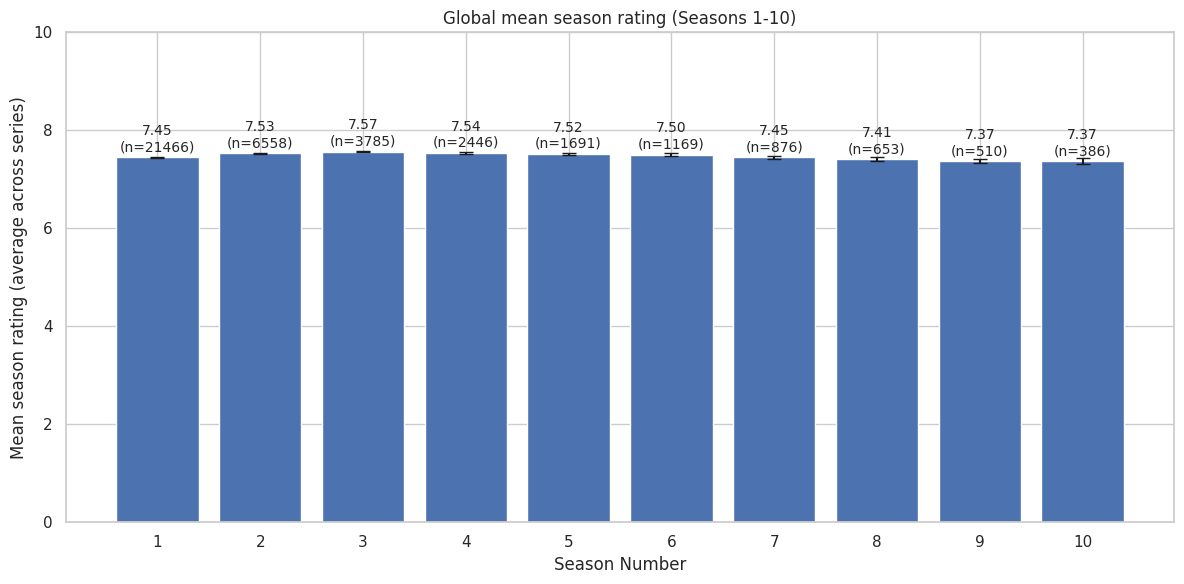

In [17]:
MAX_SEASON = MAX_SEASON_PLOT
gplot = global_df[global_df['seasonNumber'].between(1, MAX_SEASON)].copy()
fig, ax = plt.subplots(figsize=(12,6))
bars = ax.bar(gplot['seasonNumber'].astype(int).astype(str),
              gplot['mean_of_season_means'],
              yerr=gplot['sem'], capsize=5)
ax.set_ylim(0,10)
ax.set_xlabel('Season Number')
ax.set_ylabel('Mean season rating (average across series)')
ax.set_title(f'Global mean season rating (Seasons 1-{MAX_SEASON})')
for b, val, cnt in zip(bars, gplot['mean_of_season_means'], gplot['count_series']):
    ax.text(b.get_x()+b.get_width()/2, val + 0.06, f"{val:.2f}\n(n={int(cnt)})",
            ha='center', va='bottom', fontsize=10)
plt.tight_layout()
fig.savefig(outdir / 'global_mean_by_season_bar.png', dpi=200)
plt.show()


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


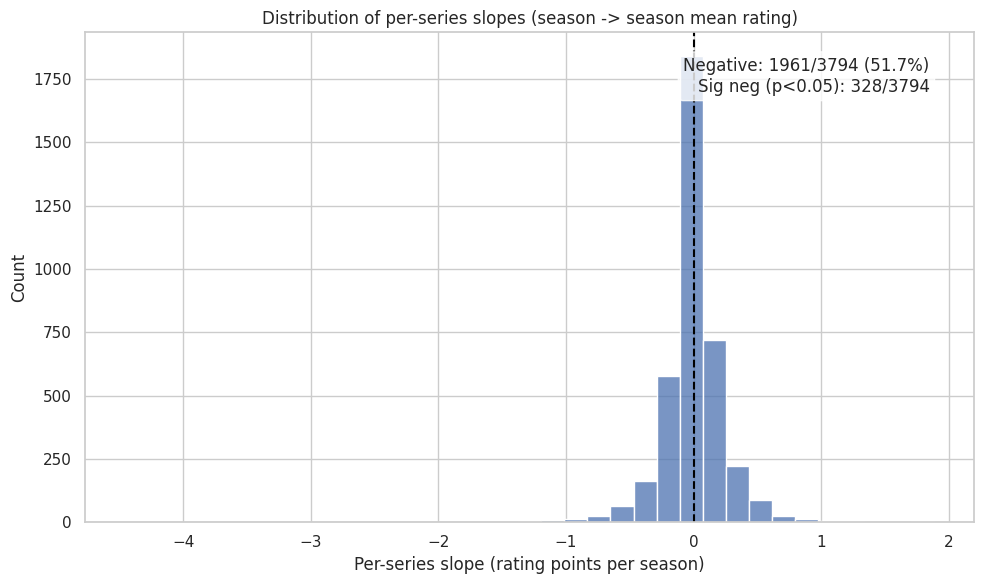

In [18]:
fig, ax = plt.subplots(figsize=(10,6))
sns.histplot(slopes_df['slope'].dropna(), bins=35, ax=ax)
ax.axvline(0, color='black', linestyle='--')
ax.set_xlabel('Per-series slope (rating points per season)')
ax.set_title('Distribution of per-series slopes (season -> season mean rating)')
ax.text(0.95, 0.95,
        f"Negative: {neg_count}/{total} ({100*neg_count/total:.1f}%)\nSig neg (p<0.05): {sig_neg_count}/{total}",
        transform=ax.transAxes, ha='right', va='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
plt.tight_layout()
fig.savefig(outdir / 'per_series_slopes_hist.png', dpi=200)
plt.show()


Deep-dive shows used: ['Game of Thrones', 'Breaking Bad', 'The Walking Dead', 'Friends']


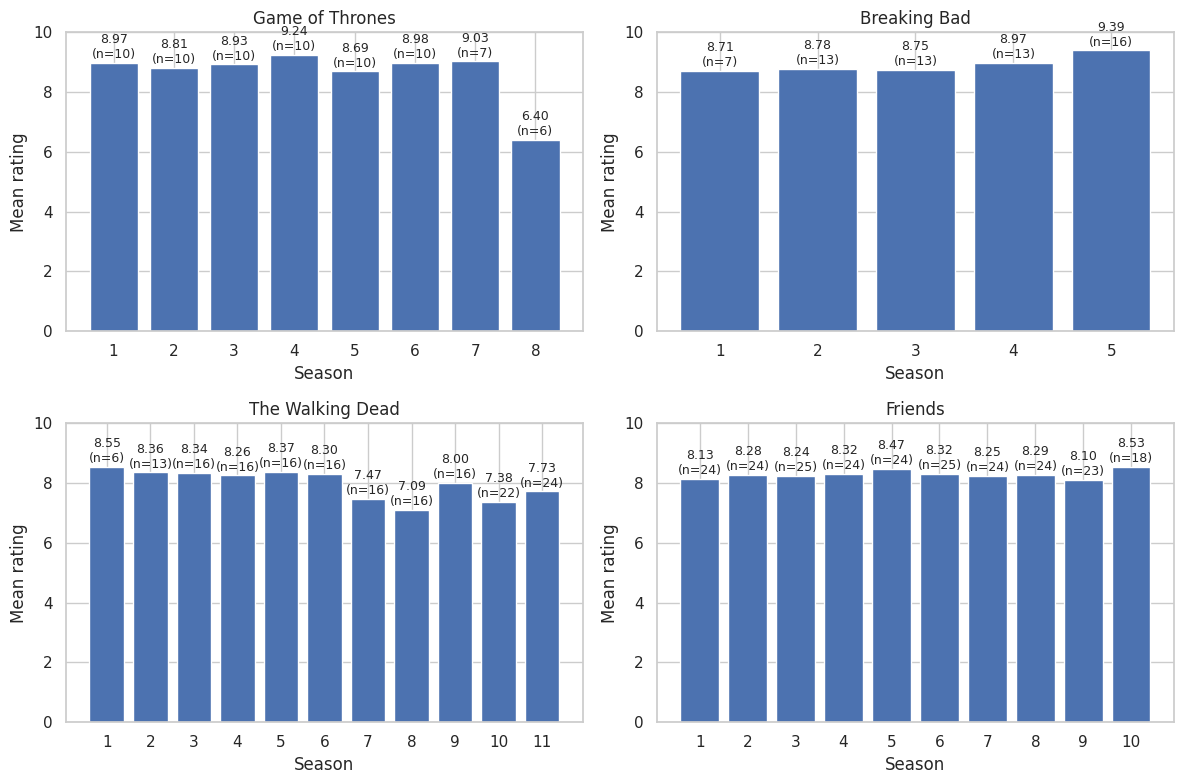

In [19]:
season_df['series_title_lower'] = season_df['series_title'].str.lower()

found = {}
for name in SHOWS_TO_ANALYZE:
    q = season_df[season_df['series_title_lower'] == name.lower()]
    if not q.empty:
        found[name] = q.sort_values('seasonNumber')

# fallback: fill up with top multi-season shows
if len(found) < len(SHOWS_TO_ANALYZE):
    top_multi = season_df.groupby(['series_tconst','series_title']).seasonNumber.nunique().reset_index(name='n_seasons').sort_values('n_seasons', ascending=False)
    for _, r in top_multi.iterrows():
        t = r['series_title']
        if t not in found:
            q = season_df[season_df['series_tconst'] == r['series_tconst']]
            if not q.empty:
                found[t] = q.sort_values('seasonNumber')
        if len(found) >= len(SHOWS_TO_ANALYZE):
            break

print("Deep-dive shows used:", list(found.keys()))

n = len(found)
cols = 2
rows = (n + cols - 1) // cols
fig, axs = plt.subplots(rows, cols, figsize=(6*cols, 4*rows), squeeze=False)
axs = axs.flatten()
for ax_idx, (title, df_show) in enumerate(found.items()):
    ax = axs[ax_idx]
    df_plot = df_show[df_show['seasonNumber'] <= MAX_SEASON_TOPN]
    x = df_plot['seasonNumber'].astype(int).astype(str)
    y = df_plot['season_mean_rating']
    counts = df_plot['season_count']
    bars = ax.bar(x, y)
    ax.set_ylim(0,10)
    ax.set_title(title)
    ax.set_xlabel('Season')
    ax.set_ylabel('Mean rating')
    for b, val, cnt in zip(bars, y, counts):
        ax.text(b.get_x()+b.get_width()/2, val + 0.06, f"{val:.2f}\n(n={int(cnt)})", ha='center', va='bottom', fontsize=9)
for i in range(len(found), len(axs)):
    fig.delaxes(axs[i])
plt.tight_layout()
fig.savefig(outdir / 'multi_show_deepdive.png', dpi=200)
plt.show()


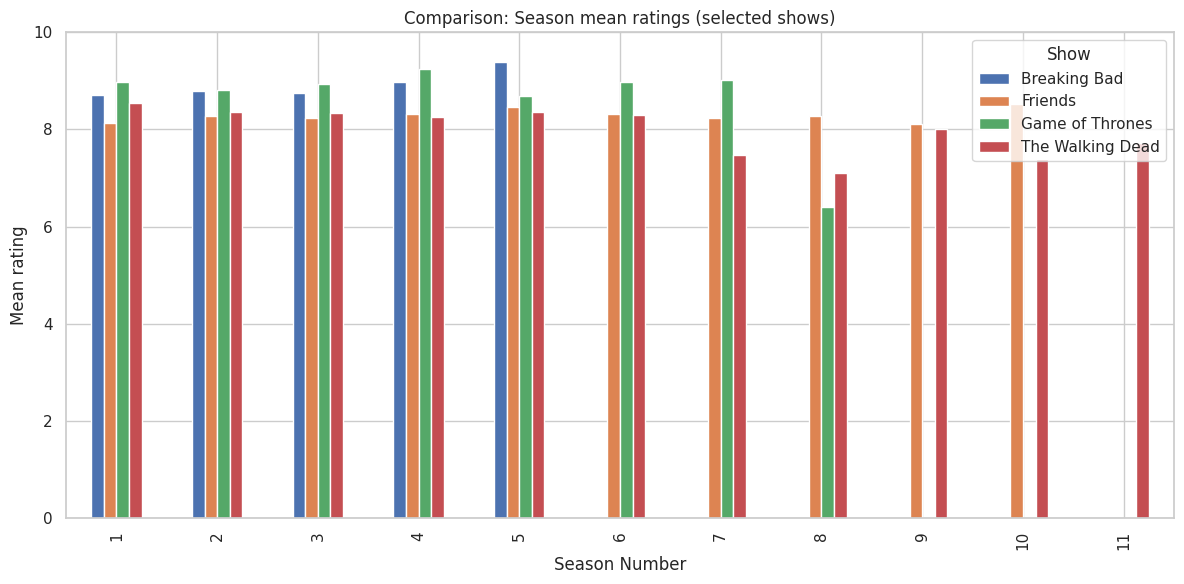

In [20]:
combined = []
for title, df_show in found.items():
    tmp = df_show[['series_title','seasonNumber','season_mean_rating']].copy()
    combined.append(tmp)
combined_df = pd.concat(combined, ignore_index=True)
pivot = combined_df.pivot(index='seasonNumber', columns='series_title', values='season_mean_rating').sort_index()
pivot = pivot.loc[(pivot.index >= 1) & (pivot.index <= MAX_SEASON_TOPN)]
fig, ax = plt.subplots(figsize=(12,6))
pivot.plot(kind='bar', ax=ax)
ax.set_ylim(0,10)
ax.set_xlabel('Season Number')
ax.set_ylabel('Mean rating')
ax.set_title('Comparison: Season mean ratings (selected shows)')
ax.legend(title='Show', loc='best')
plt.tight_layout()
fig.savefig(outdir / 'combined_selected_shows_grouped_bar.png', dpi=200)
plt.show()


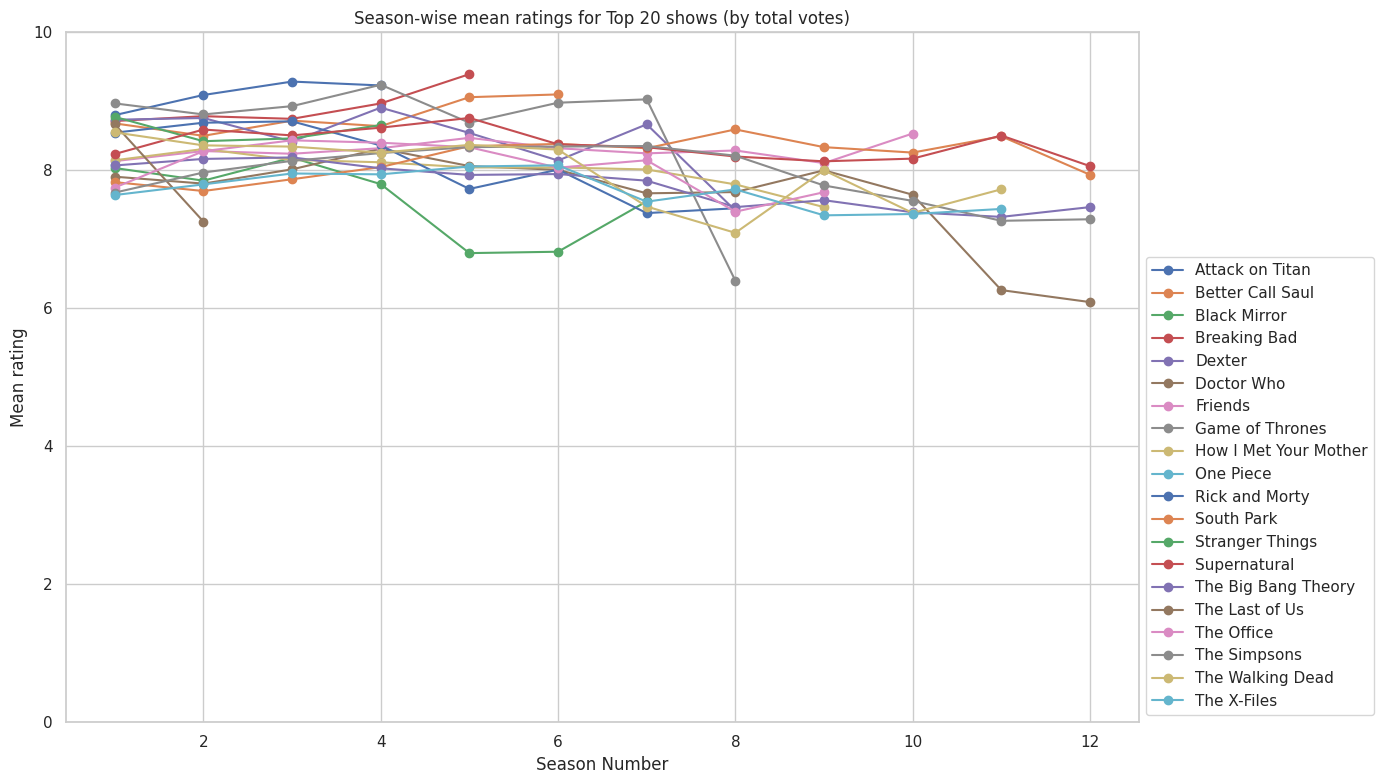

In [21]:
series_votes = con.execute("""
SELECT series_tconst, SUM(numVotes) AS total_votes
FROM ep_with_ratings
GROUP BY series_tconst
""").fetchdf()

series_meta = season_df.groupby(['series_tconst','series_title']).seasonNumber.nunique().reset_index(name='n_seasons')
series_meta = series_meta.merge(series_votes, on='series_tconst', how='left').fillna(0)
top_series = series_meta.sort_values('total_votes', ascending=False).head(TOP_N_SHOWS)

top_list = top_series['series_tconst'].tolist()
top_seasons = season_df[season_df['series_tconst'].isin(top_list)].copy()
pivot_top = top_seasons.pivot_table(index='seasonNumber', columns='series_title', values='season_mean_rating', aggfunc='mean')
pivot_top = pivot_top.loc[(pivot_top.index >= 1) & (pivot_top.index <= MAX_SEASON_TOPN)]

fig, ax = plt.subplots(figsize=(14,8))
for col in pivot_top.columns:
    ax.plot(pivot_top.index, pivot_top[col], marker='o', label=col)
ax.set_ylim(0,10)
ax.set_xlabel('Season Number')
ax.set_ylabel('Mean rating')
ax.set_title(f'Season-wise mean ratings for Top {TOP_N_SHOWS} shows (by total votes)')
ax.legend(loc='lower left', bbox_to_anchor=(1.0, 0.0), ncol=1)
plt.tight_layout()
fig.savefig(outdir / f'top{TOP_N_SHOWS}_season_lines.png', dpi=200)
plt.show()


In [22]:
global_df.to_csv(outdir / 'global_by_season.csv', index=False)
season_df.to_csv(outdir / 'season_by_series.csv', index=False)
slopes_df.to_csv(outdir / 'per_series_slopes.csv', index=False)
print("Saved CSVs and plots to:", outdir)


if not np.isnan(slope):
    print(f"Global linear trend (seasons with >= {MIN_SERIES_PER_SEASON} series): slope = {slope:.4f} rating pts/season, p = {p_value:.3g}, r = {r_value:.3f}")
else:
    print("Global trend not computed (not enough seasons with sufficient series).")
print(f"Series with >= {MIN_SEASONS} seasons used: {total}")
print(f"Series with negative slope: {neg_count} ({100*neg_count/total:.1f}%)")
print(f"Series with significant negative slope (p<0.05): {sig_neg_count} ({100*sig_neg_count/total:.1f}%)")


Saved CSVs and plots to: /content/rating_decay_outputs_proof
Global linear trend (seasons with >= 10 series): slope = -0.0014 rating pts/season, p = 0.403, r = -0.121
Series with >= 3 seasons used: 3794
Series with negative slope: 1961 (51.7%)
Series with significant negative slope (p<0.05): 328 (8.6%)


# Key Insights 

- **Global Ratings Stay Stable**
    Season 1–10 average ratings remain around 7.4–7.6, showing no strong overall rating decay.

- **Half of Multi-Season Shows Decline**
    About 52% of shows (with ≥3 seasons) have a downward slope, but most declines are small.

- **Decay Is Not Universal**
    Some shows improve (e.g., Breaking Bad), some stay stable (Friends), and some decline (The Walking Dead).
    Rating trends vary widely between shows.

- **Popular Shows Also Show Mixed Patterns**
    Top-20 shows include a mix of improvers, stable shows, and decliners — no single pattern fits all.
    
- **Overall Conclusion**
    Rating decay exists but is usually mild.
